In [128]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
import random
import mplcursors
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from ipywidgets import interactive, Layout
from tqdm import tqdm
import ipywidgets as widgets

from IPython.display import display, clear_output

from GridDataGen.utils.io import *
from GridDataGen.utils.process_network import *
from GridDataGen.utils.config import *
from GridDataGen.utils.stats import *
from GridDataGen.utils.param_handler import *
from GridDataGen.utils.load import *
from GridDataGen.utils.solvers import *
from pandapower.auxiliary import pandapowerNet

from typing import Optional, Union

import pandapower as pp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#%matplotlib 
%matplotlib widget


### Case300

In [ ]:
class Grid(object):
    
    node_types = {1:"PQ", 2:"PV", 3:"REF"}
    node_shapes = {"REF": "s", "PV": "^", "PQ": "o"}
    node_sizes = {"REF": 25, "PV": 15, "PQ": 10}
        
    def __init__(self, data_root:str, model_output_fn:str):
        
        assert os.path.isdir(data_root), f"Data root folder not found: {data_root}"
        self.data_root = data_root

        node_path = os.path.join(data_root, "pf_node.csv")
        edge_path = os.path.join(data_root, "pf_edge.csv")
        bus_params_path = os.path.join(data_root, "bus_params.csv")
        edge_params_path = os.path.join(data_root, "edge_params.csv")
        branch_idx_removed_path = os.path.join(data_root, "branch_idx_removed.csv")

        node_data_df = pd.read_csv(node_path)
        #self.edge_df = pd.read_csv(edge_path) 
        self.bus_params = pd.read_csv(bus_params_path)
        self.edge_params = pd.read_csv(edge_params_path, dtype={'from_bus': 'int', 'to_bus': 'int'})
        edges_dropped_df = pd.read_csv(branch_idx_removed_path)
                
        model_output_path = os.path.join(data_root, model_output_fn)
        assert os.path.isfile(model_output_path), f"Model output file not found: {model_output_path}"
        node_model_df = pd.read_csv(model_output_path)
        node_model_df = node_model_df.drop(node_model_df.columns[0], axis=1)
        node_model_df.drop(columns=["PQ","PV","REF"], axis=1, inplace=True)
        suffix_cols = ["PD", "QD", "PG", "QG", "VM", "VA"]
        suffix = "_pred"
        cols_renamed = {col:col+suffix for col in suffix_cols}
        node_model_df = node_model_df.rename(columns=cols_renamed)
        self.node_data = node_data_df.merge(node_model_df, left_on=['scenario','bus'], right_on = ['scenario','bus'], how='inner')
        del node_data_df, node_model_df

        # convert branch_idx_removed data to scenario -> line index list lookup dict
        #node_data_scenarios = list(self.node_data["scenario"].unique().astype(np.int32))
        self.edges_dropped = {
            k:[np.int32(x) for x in sorted([v1, v2]) if not np.isnan(x)] 
            for (k, v1, v2) in 
            zip(edges_dropped_df.scenario.tolist(), 
                edges_dropped_df["0"].tolist(), 
                edges_dropped_df["1"].tolist()
                )
            #if k in node_data_scenarios
        }

        # filter scenarios according to model predictions and data gen overlap
        #self.edges_dropped = {k:v for k,v in self.edges_dropped.items() if k in node_data_scenarios}
        
        # create dictionary to map lines dropped to all scenarios
        self.contingency_cases = {}
        for key, val in self.edges_dropped.items():
            tuple_val = tuple(val)#frozenset(val)
            if tuple_val in self.contingency_cases:
                self.contingency_cases[tuple_val].append(key)
            else:
                self.contingency_cases[tuple_val] = [key]

        # create list of selectable scenarios by user, based on unique scenarios from node_data
        self.selectable_scenarios = list(self.node_data["scenario"].unique().astype(np.int32))

        # Correct model outputs of Voltage magnitude and angle values for PV busses
        self.node_data["VM_pred_corrected"] = self.node_data["VM_pred"]
        self.node_data["VA_pred_corrected"] = self.node_data["VA_pred"]
        self.node_data.loc[self.node_data.PV==1, "VM_pred_corrected"] = self.node_data.loc[self.node_data.PV==1, "Vm"]
        self.node_data.loc[self.node_data.REF==1, "VA_pred_corrected"] = self.node_data.loc[self.node_data.REF==1, "Va"]

        self.sn_mva = 100
        base_kV = self.bus_params["baseKV"].values

        # Extract from- and to-bus indices
        from_idx = self.edge_params["from_bus"].values.astype(np.int32)
        to_idx = self.edge_params["to_bus"].values.astype(np.int32)

        # Extract branch admittance coefficients
        Yff = self.edge_params["Yff_r"].values + 1j * self.edge_params["Yff_i"].values
        Yft = self.edge_params["Yft_r"].values + 1j * self.edge_params["Yft_i"].values
        Ytf = self.edge_params["Ytf_r"].values + 1j * self.edge_params["Ytf_i"].values
        Ytt = self.edge_params["Ytt_r"].values + 1j * self.edge_params["Ytt_i"].values

        # Extract base voltages for from- and to-busses
        self.Vf_base_kV = base_kV[from_idx]
        self.Vt_base_kV = base_kV[to_idx]

        # Number of lines/edges and busses
        nl = self.edge_params.shape[0]
        nb = self.bus_params.shape[0]

        # i = [0, 1, ..., nl-1, 0, 1, ..., nl-1], used for constructing Yf and Yt
        i = np.hstack([np.arange(nl), np.arange(nl)])

        # Construct from-end admittance matrix Yf using the linear combination:
        # Yf[b, :] = y_ff_b * e_f + y_ft_b * e_t
        self.Yf = csr_matrix((np.hstack([Yff, Yft]), (i, np.hstack([from_idx, to_idx]))), shape=(nl, nb))
        self.Yt = csr_matrix((np.hstack([Ytf, Ytt]), (i, np.hstack([from_idx, to_idx]))), shape=(nl, nb))

        self.rate_a = self.edge_params["rate_a"].values

        del Yff, Yft, Ytf, Ytt

        # create map between edge index and node tuples
        self.edge_idx_map = {
            i:(u,v) 
            for i, (u,v) in enumerate(
                zip(
                    self.edge_params["from_bus"].tolist(),
                    self.edge_params["to_bus"].tolist())
                    )
                    }
        
        # Construct a base graph from all the lines and nodes
        self.Gb, self.Gb_pos = self._create_graph()


    def _calc_V(self, vm:np.ndarray, va:np.ndarray) -> np.ndarray:
        """
        """
        V = vm * np.exp(1j * va * np.pi/180.0)
        return V
    

    def _calc_I(self, V:np.ndarray) -> np.ndarray:
        """
        """
        If_pu = self.Yf @ V  # From-end currents in per-unit (I_f = Y_f V)
        If_kA = np.abs(If_pu) * self.sn_mva / (np.sqrt(3) * self.Vf_base_kV)  # Conversion to kA

        # Construct to-end admittance matrix Yt:
        # Yt[b, :] = y_tf_b * e_f + y_tt_b * e_t
        It_pu = self.Yt @ V  # To-end currents in per-unit (I_t = Y_t V)
        It_kA = np.abs(It_pu) * self.sn_mva / (np.sqrt(3) * self.Vt_base_kV)  # Conversion to kA

        return If_kA, It_kA
    

    def _calc_loading(self, If_kA:np.ndarray, It_kA:np.ndarray) -> np.ndarray:
        """
        """
        limitf = self.rate_a / (self.Vf_base_kV * np.sqrt(3))
        limitt = self.rate_a / (self.Vt_base_kV * np.sqrt(3))

        loadingf = If_kA / limitf
        loadingt = It_kA / limitt

        return np.maximum(loadingf, loadingt)
            

    def compute_loadings(self):#, scenario:Optional[Union[int,list]]=None):
        
        nl = self.edge_params.shape[0]
        scenario_l, from_bus_l, to_bus_l = [], [], []
        rate_a = []
        If_true_l, It_true_l, If_pred_l, It_pred_l = [], [], [], []
        loading_true_l, loading_pred_l = [], []

        for cidx, sidx in enumerate(tqdm(self.node_data["scenario"].unique(), desc="Computing loadings")):

            node_df_sidx = self.node_data[self.node_data["scenario"] == sidx]

            # construct complex voltages
            V_true = self._calc_V(node_df_sidx["Vm"].values, 
                                  node_df_sidx["Va"].values)
            V_pred = self._calc_V(node_df_sidx["VM_pred_corrected"].values, 
                                  node_df_sidx["VA_pred_corrected"].values)
            #print(np.shape(V_true), np.shape(V_pred))

            # calculate currents
            If_true, It_true = self._calc_I(V_true)
            If_pred, It_pred = self._calc_I(V_pred)

            # calculate loadings
            loading_true = self._calc_loading(If_true, It_true)
            loading_pred = self._calc_loading(If_pred, It_pred)
            #print(np.shape(loading_true), np.shape(loading_pred))

            # remove dropped lines
            edges_dropped = self.edges_dropped[sidx]
            loading_true[edges_dropped] = np.nan
            loading_pred[edges_dropped] = np.nan

            # TODO Need to make this pandas code more efficient
            # add loadings to edge_params
            scenario_l += [sidx]*nl
            from_bus_l += self.edge_params["from_bus"].tolist()
            to_bus_l += self.edge_params["to_bus"].tolist()
            rate_a += self.edge_params["rate_a"].tolist()
            If_true_l += list(If_true)
            It_true_l += list(It_true)
            If_pred_l += list(If_pred)
            It_pred_l += list(It_pred)
            loading_true_l += list(loading_true)
            loading_pred_l += list(loading_pred)

        # create edge_data data-frame to store information for plotting
        self.edge_data = pd.DataFrame(
            {
                "scenario": scenario_l,
                "from_bus": from_bus_l,
                "to_bus": to_bus_l,
                "rate_a": rate_a,
                "If_true": If_true_l,
                "It_true": It_true_l,
                "If_pred": If_pred_l,
                "It_pred": It_pred_l,
                "loading_true": loading_true_l,
                "loading_pred": loading_pred_l
                }
                )
        
    def _create_graph(self):
        """
        """
        
        # create list of all nodes with parameters as data
        graph_nodes = [ 
            (np.int32(u), {"type":Grid.node_types[t], "vmin":vmn, "vmax":vmx, "baseKV":bkv})
            #np.int32(u)
            for u, t, vmn, vmx, bkv in zip(
                self.bus_params.bus.tolist(),
                self.bus_params.type.tolist(),
                self.bus_params.vmin.tolist(),
                self.bus_params.vmax.tolist(),
                self.bus_params.baseKV.tolist()
            )
        ]

        # create list of all edges with parameters as data
        graph_edges = [
            (np.int32(u), np.int32(v), {"rate_a":rate_a})
            #(np.int32(u), np.int32(v))
            for u, v, rate_a in zip(
                self.edge_params.from_bus.tolist(),
                self.edge_params.to_bus.tolist(),
                self.edge_params.rate_a.tolist()
            )
            if u != v
            ]
        
        # create graph
        #G = nx.MultiGraph()
        G = nx.Graph()
        G.add_nodes_from(graph_nodes)
        G.add_edges_from(graph_edges)
        
        # set node positions
        #pos = nx.spring_layout(G, seed=42)
        pos = nx.spectral_layout(G)
        #self.G_pos = nx.planar_layout(self.Gb)

        return G, pos
    

    def plot_grid(self):
        pass



In [135]:
data_root = "/Users/etiennevos/IBM_work/gridFM/grid_data_synthetic/notebooks/case300_ieee/raw"
model_output_fn = "GridFM_v0.2.3_case300_ieee_output_pf_node.csv"
grid = Grid(
    data_root=data_root,
    model_output_fn=model_output_fn
)

In [136]:
grid.compute_loadings()

Computing loadings: 100%|██████████| 10234/10234 [00:13<00:00, 780.94it/s]


In [ ]:
#gvals_rounded = [np.round(x,3) for x in g_vals]
#labels = {(u, v) : gvals_rounded[v] for u, v in edges}
# print(dfn_con.head(10))
# print("-----")
# print(dfe_con.head(10))

# for nt, ns in grid.node_shapes.items():
#     nodes = [np.int32(nid) for nid, ndat in grid.Gb.nodes(data=True) if ndat['type'] == nt]
#     nx.draw_networkx_nodes(
#         grid.Gb,
#         grid.Gb_pos,
#         nodelist=nodes,
#         #node_color=[predicted_values[i] for i in nodes],
#         cmap=plt.cm.jet,
#         node_size=grid.node_sizes[nt],
#         #ax=ax[0],
#         #vmin=vmin,
#         #vmax=vmax,
#         node_shape=grid.node_shapes[nt],
#         )

contingency scenario:  3
edges_dropped:  [179]
scenarios with lines dropped (selectable):  [3, 2047, 2836, 4306, 4938, 14471, 16893, 19232, 22168, 24259, 32578, 32612, 34040, 39553, 46077, 47585, 53568, 54347, 54733, 55534, 66742, 67782, 75032, 78815, 79534, 80891, 83193, 83764, 84282, 84324, 93670, 97335, 100019]


/Users/etiennevos/miniforge3/envs/gridfm2-folium/lib/python3.12/site-packages/mplcursors/_pick_info.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


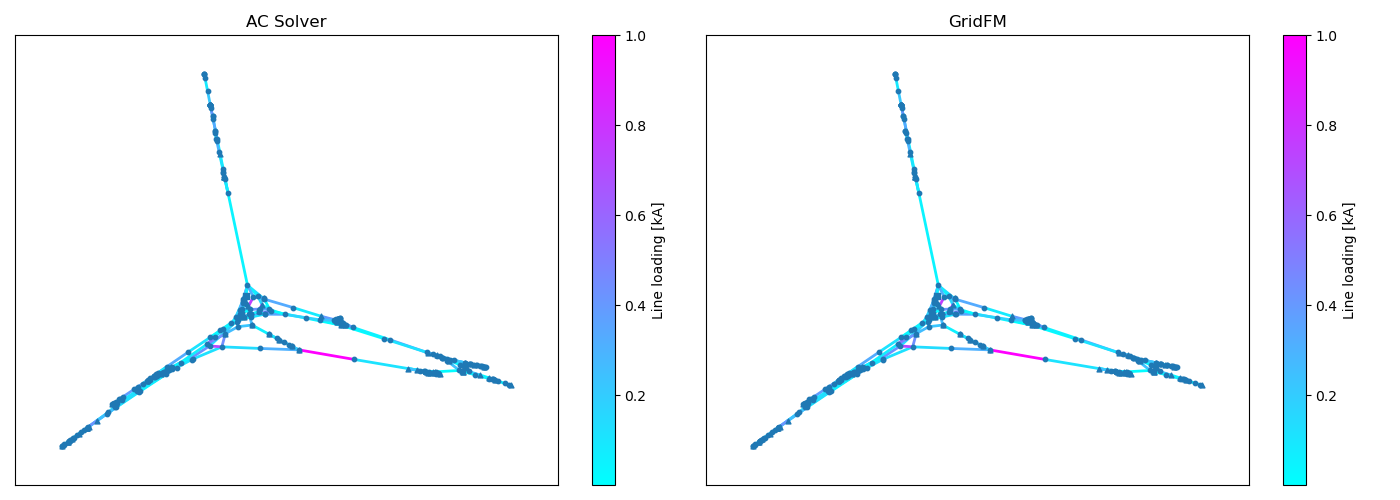

In [ ]:
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, figure=fig)

plt.clf()

contingency_scenario = grid.selectable_scenarios[0] # slider for user to pick a "selectable_scenario"
print(f"contingency scenario: ", contingency_scenario)
edges_dropped = grid.edges_dropped[contingency_scenario]
print(f"edges_dropped: ", edges_dropped)
contingency_cases = sorted(list(set(grid.contingency_cases[tuple(edges_dropped)]).intersection(set(grid.selectable_scenarios))))
print(f"scenarios with lines dropped (selectable): ", contingency_cases)

dfn = grid.node_data[grid.node_data.scenario.isin(contingency_cases)]
dfe = grid.edge_data[grid.edge_data.scenario.isin(contingency_cases)]

# select first valid/selectable contingency
dfn_con = dfn[dfn.scenario == contingency_scenario]
dfe_con = dfe[dfe.scenario == contingency_scenario]

# ===========left plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("AC Solver")

edges_plot = [(u,v) for u,v in zip(dfe_con.from_bus.tolist(), dfe_con.to_bus.tolist())]
edge_vals = dfe_con["loading_true"].tolist()

norm = colors.Normalize(vmin=min(edge_vals), vmax=max(edge_vals))
cmap = plt.get_cmap('cool')
edge_colors = cmap(norm(edge_vals))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Line loading [kA]', ax=ax1)

for nt, ns in grid.node_shapes.items():
    nodes = [np.int32(nid) for nid, ndat in grid.Gb.nodes(data=True) if ndat['type'] == nt]
    nx.draw_networkx_nodes(
        grid.Gb,
        grid.Gb_pos,
        nodelist=nodes,
        cmap=plt.cm.jet,
        ax=ax1,
        node_size=grid.node_sizes[nt],
        node_shape=grid.node_shapes[nt],
        )
    
nx.draw_networkx_edges(grid.Gb, 
                       grid.Gb_pos,
                       edge_color=edge_colors,
                       #edge_color="gray",
                       ax=ax1,
                       width=2)


# ===========right plot
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("GridFM")

edges_plot = [(u,v) for u,v in zip(dfe_con.from_bus.tolist(), dfe_con.to_bus.tolist())]
edge_vals = dfe_con["loading_pred"].tolist()

norm = colors.Normalize(vmin=min(edge_vals), vmax=max(edge_vals))
cmap = plt.get_cmap('cool')
edge_colors = cmap(norm(edge_vals))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Line loading [kA]', ax=ax2)

# nx.draw_networkx_nodes(
#     grid.Gb,
#     grid.Gb_pos,
#     nodelist=[np.int32(nid) for nid in grid.Gb.nodes()],
#     node_size=20,#grid.node_sizes[nt],
#     ax=ax2,
#     node_shape='o'#grid.node_shapes[nt],
#     )

for nt, ns in grid.node_shapes.items():
    nodes = [np.int32(nid) for nid, ndat in grid.Gb.nodes(data=True) if ndat['type'] == nt]
    nx.draw_networkx_nodes(
        grid.Gb,
        grid.Gb_pos,
        nodelist=nodes,
        cmap=plt.cm.jet,
        ax=ax2,
        node_size=grid.node_sizes[nt],
        node_shape=grid.node_shapes[nt],
        )
    
nx.draw_networkx_edges(grid.Gb, 
                       grid.Gb_pos,
                       edge_color=edge_colors,
                       #edge_color="gray",
                       ax=ax2,
                       width=2)

plt.tight_layout()
fig.canvas.header_visible = False
#plt.show()

In [141]:
dfn_con.head(10)

,scenario,bus,Pd,Qd,Pg,Qg,Vm,Va,PQ,PV,REF,PD_pred,QD_pred,PG_pred,QG_pred,VM_pred,VA_pred,VM_pred_corrected,VA_pred_corrected
0,3,0,50.664416,49.0,0.000000e+00,0.000000,1.044401,4.455041,1.0,0.0,0.0,-1.563661,2.722783,-49.102707,31.250828,1.044433,4.347853,1.044433,4.347853
1,3,1,31.524526,15.0,0.000000e+00,0.000000,1.046614,10.138186,1.0,0.0,0.0,0.362053,4.031973,-231.418580,45.795080,1.046618,10.027755,1.046618,10.027755
2,3,2,11.258759,0.0,0.000000e+00,0.000000,1.017601,6.933614,1.0,0.0,0.0,-0.731800,-1.966039,-101.235756,0.959754,1.017688,6.821839,1.017688,6.821839
3,3,3,0.000000,0.0,0.000000e+00,0.000000,0.992464,5.312923,1.0,0.0,0.0,-1.056011,-2.371057,-101.206350,7.380746,0.992589,5.213551,0.992589,5.213551
4,3,4,198.717099,130.0,0.000000e+00,0.000000,1.038654,4.368916,1.0,0.0,0.0,-0.974825,1.966268,-33.039040,25.441032,1.038694,4.261863,1.038694,4.261863
5,3,5,67.552555,41.0,0.000000e+00,0.000000,1.043797,9.129317,1.0,0.0,0.0,-0.456009,2.347558,-193.179780,39.010277,1.043814,9.018177,1.043814,9.018177
6,3,6,0.000000,0.0,0.000000e+00,0.000000,1.014567,6.154553,1.0,0.0,0.0,-1.000107,-1.658927,-80.254150,2.262210,1.014648,6.041238,1.014648,6.041238
7,3,7,35.465091,14.0,1.178987e-14,10.125139,1.024237,5.908002,0.0,1.0,0.0,0.215691,3.332713,-72.573380,9.923124,1.027144,5.810503,1.024237,5.810503
8,3,8,54.042044,43.0,0.000000e+00,0.000000,1.029916,5.562756,1.0,0.0,0.0,0.106996,2.248163,-46.632330,9.541141,1.029934,5.454982,1.029934,5.454982
9,3,9,86.129507,33.0,1.127757e-14,20.101467,1.047666,3.672520,0.0,1.0,0.0,1.987528,6.793261,-2.474834,19.963665,1.037884,3.566234,1.047666,3.566234


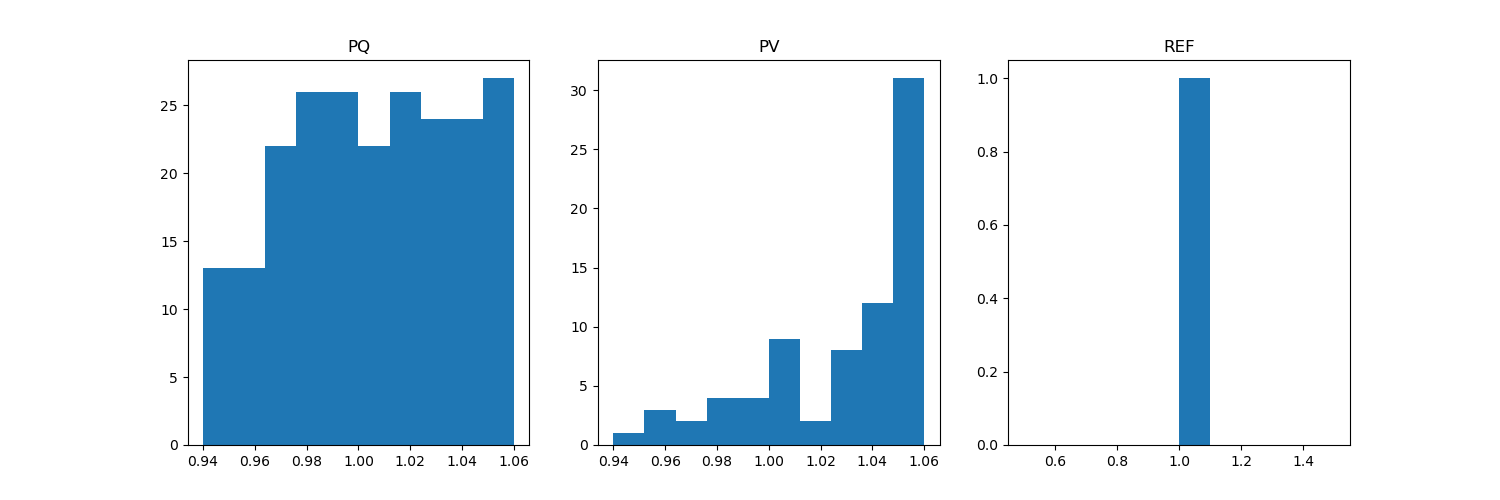

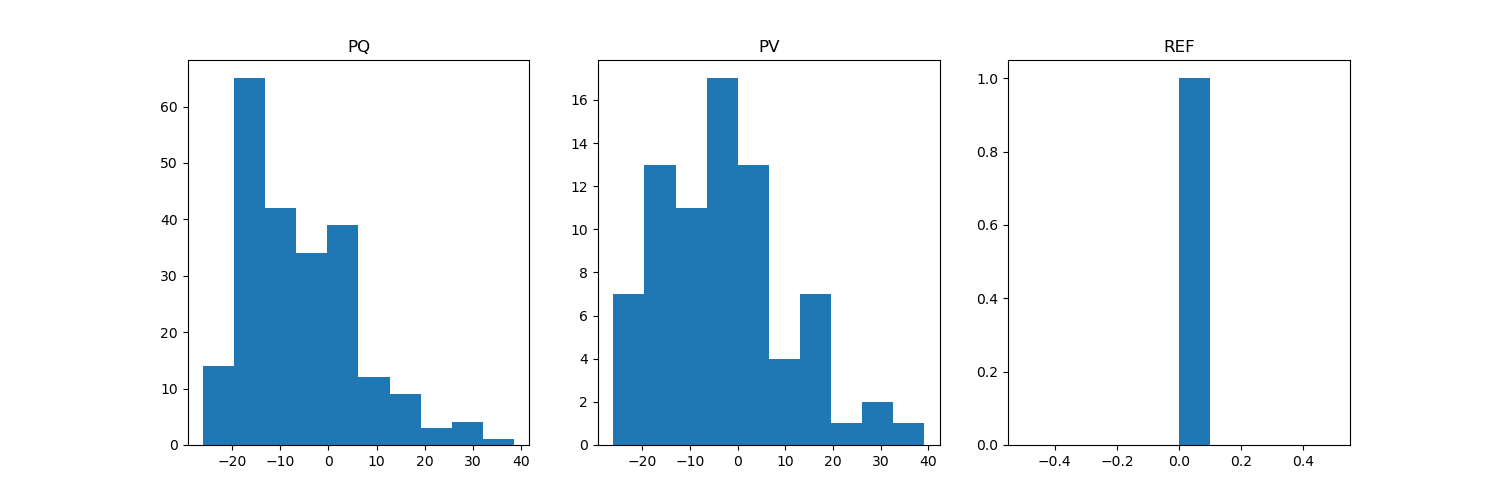

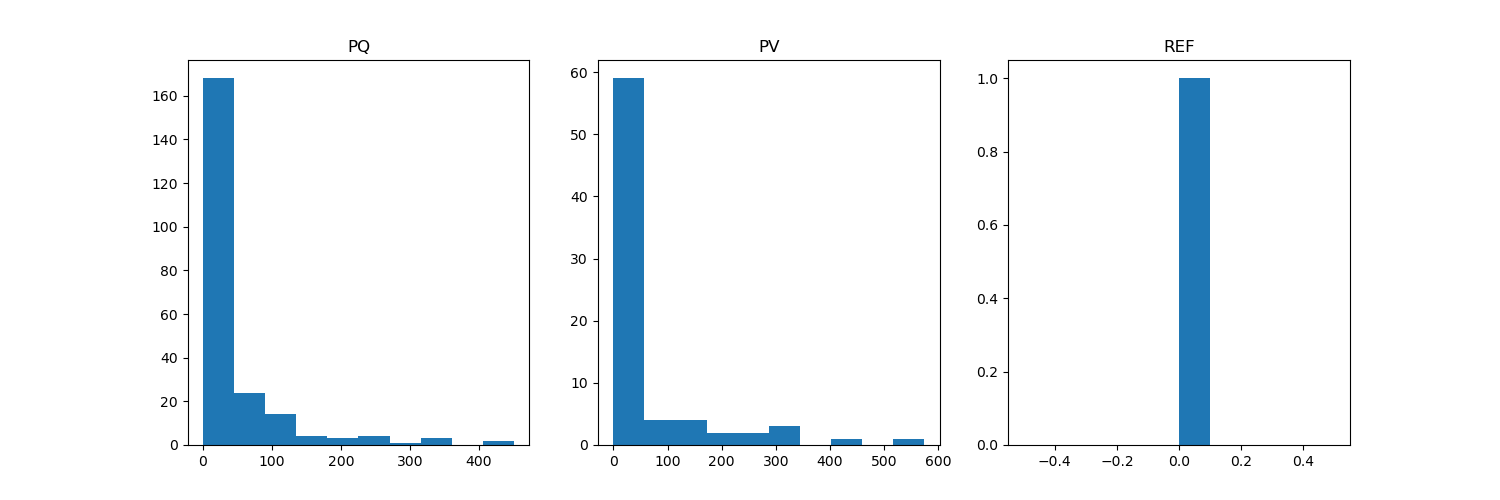

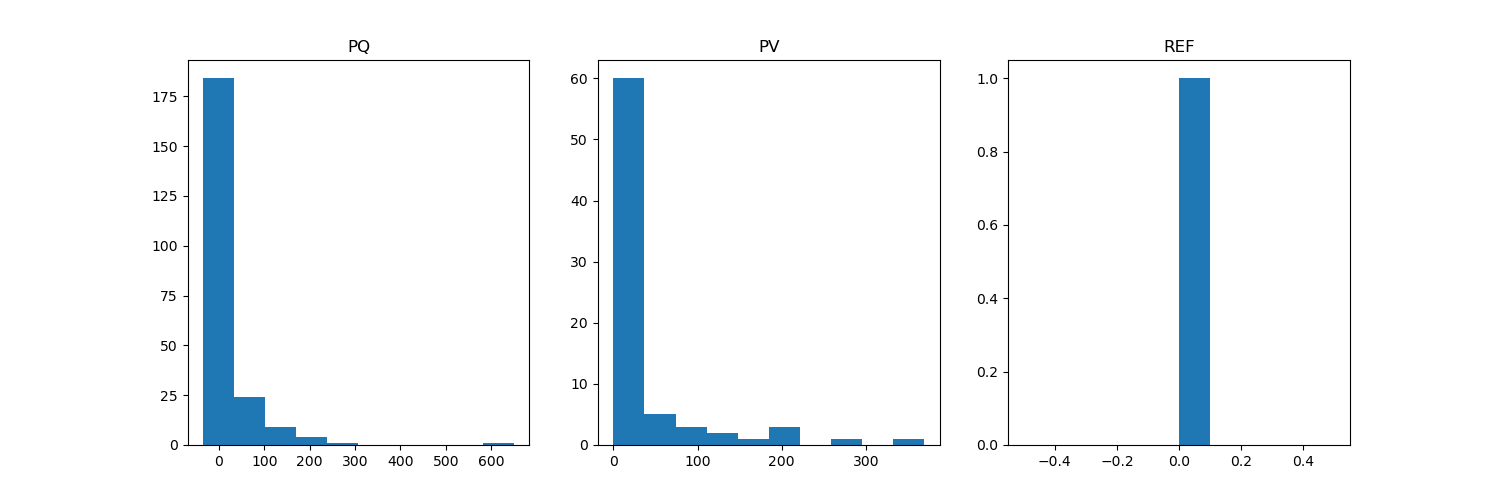

In [145]:
dfn_con.head(10)
dfnc_pq = dfn_con[dfn_con.PQ==1.0]
dfnc_pv = dfn_con[dfn_con.PV==1.0]
dfnc_ref = dfn_con[dfn_con.REF==1.0]

for v in ["Vm", "Va", "Pd", "Qd"]:
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].hist(dfnc_pq[v].values, bins=10)
    ax[0].set_title("PQ")

    ax[1].hist(dfnc_pv[v].values, bins=10)
    ax[1].set_title("PV")

    ax[2].hist(dfnc_ref[v].values, bins=10)
    ax[2].set_title("REF")
    plt.show()



In [8]:
grid.edge_data.head(3)

,scenario,from_bus,to_bus,rate_a,If_true,It_true,If_pred,It_pred,loading_true,loading_pred
0,3,265,269,8215.0,0.227764,0.227764,0.227409,0.227409,0.005523,0.005514
1,3,270,271,117.0,0.511342,0.511342,0.511157,0.511157,0.049961,0.049943
2,3,270,267,59.0,0.448668,0.448668,0.448931,0.448931,0.086932,0.086983


In [9]:
grid.node_data.head(3)

,scenario,bus,Pd,Qd,Pg,Qg,Vm,Va,PQ,PV,REF,PD_pred,QD_pred,PG_pred,QG_pred,VM_pred,VA_pred,VM_pred_corrected,VA_pred_corrected
0,3,0,50.664416,49.0,0.0,0.0,1.044401,4.455041,1.0,0.0,0.0,-1.563661,2.722783,-49.102707,31.250828,1.044433,4.347853,1.044433,4.347853
1,3,1,31.524526,15.0,0.0,0.0,1.046614,10.138186,1.0,0.0,0.0,0.362053,4.031973,-231.418580,45.795080,1.046618,10.027755,1.046618,10.027755
2,3,2,11.258759,0.0,0.0,0.0,1.017601,6.933614,1.0,0.0,0.0,-0.731800,-1.966039,-101.235756,0.959754,1.017688,6.821839,1.017688,6.821839


In [ ]:
# node_shape_list = [node_shapes[Gb.nodes[node]["type"]] for node in Gb.nodes()]
# node_size§_list = [node_sizes[Gb.nodes[node]["type"]] for node in Gb.nodes()]
fig = plt.figure(0)
plt.clf()
# nx.draw_networkx_nodes(
#         Gb,
#         Gb_pos,
#         nodelist=list(Gb.nodes()),
#         node_size=node_size_list,
#         node_shape=node_shape_list,
#     )

In [ ]:
def load_base_grid(grid_name:str) -> Tuple[pd.DataFrame, pd.DataFrame, dict]:
    """
    """

    net = load_net_from_pp(grid_name)
    network_preprocessing(net)
    net.load['p_mw'] = net.load['p_mw']*0.8
    net.load['q_mvar'] = net.load['q_mvar']*0.8
    opf_converged = run_opf(net)
    net = pf_preprocessing(net)
    pf_converged = run_pf(net)

    # Save this network to disk in the pf_node.csv and pf_edge.csv formats
    root_path = "./temp"
    os.makedirs(root_path, exist_ok=True)
    node_path = os.path.join(root_path, "pf_node.csv")
    edge_path = os.path.join(root_path, "pf_edge.csv")

    node_data = pf_post_processing(net)
    edge_data = get_adjacency_list(net)

    try:
        os.remove(node_path)
        os.remove(edge_path)
    except OSError:
        pass

    save_node_edge_data(net, node_path, edge_path, node_data, edge_data)

    # read node and edge data from csv
    edge_df = pd.read_csv(edge_path)
    node_df = pd.read_csv(node_path)

    shutil.rmtree(root_path)

    # Assign labels based on node type
    num_nodes = node_df.shape[0]
    mask_PQ = node_df.loc[:, "PQ"] == 1
    mask_PV = node_df.loc[:, "PV"] == 1
    mask_REF = node_df.loc[:, "REF"] == 1
    node_labels = {}
    for i in range(num_nodes):
        if mask_REF[i]:
            node_labels[i] = "REF"
        elif mask_PV[i]:
            node_labels[i] = "PV"
        elif mask_PQ[i]:
            node_labels[i] = "PQ"

    return node_df, edge_df, node_labels

    
def load_scenarios(data_root:str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    """

    assert os.path.isdir(data_root), f"Data root folder not found: {data_root}"

    node_path = os.path.join(data_root, "pf_node.csv")
    edge_path = os.path.join(data_root, "pf_edge.csv")
    bus_params_path = os.path.join(data_root, "bus_params.csv")
    edge_params_path = os.path.join(data_root, "edge_params.csv")
    branch_idx_removed_path = os.path.join(data_root, "branch_idx_removed.csv")
    scenarios_powergraph_path = os.path.join(data_root, "scenarios_powergraph.csv")

    node_df = pd.read_csv(node_path)
    edge_df = pd.read_csv(edge_path)

    return node_df, edge_df


def generate_nx_graph( ## rather use edge_params instead of edge_df
        node_df:pd.DataFrame, 
        edge_df:pd.DataFrame, 
        node_labels:dict, # contains all nodes, including those that could be dropped
        scenario:Optional[int] = None
        ) -> nx.graph.Graph:
    """
    """

    # filter node & edge dataframes based on given scenario
    if scenario != None:
        node_df_s = node_df[node_df["scenario"]==scenario]
        edge_df_s = edge_df[edge_df["scenario"]==scenario]
    else:
        node_df_s = node_df.copy()
        edge_df_s = edge_df.copy()

    # build nx graph
    G_ = nx.Graph()
    nodes = [ (u, {"type":node_labels[u]})
              for u in node_df_s["bus"].tolist()
              ]
    edges = [
            (u, v, {"G":g, "B":b})
            for u, v, g, b in zip(
                edge_df_s["index1"].tolist(), edge_df_s["index2"].tolist(), edge_df_s["G"].tolist(), edge_df_s["B"].tolist()
            )
            if u != v
            ]
    G_.add_nodes_from(nodes)
    G_.add_edges_from(edges)
      
    # set node positions
    pos = nx.spring_layout(G_, seed=42)

    return G_, pos
    

In [311]:
grid_name = "case300"
base_node_df, base_edge_df, node_labels = load_base_grid(grid_name);

gen vm_pu > bus max_vm_pu for gens [18 27 28]. Setting bus limit for these gens.
gen vm_pu < bus min_vm_pu for gens [22]. Setting bus limit for these gens.


In [ ]:
data_root = "/Users/etiennevos/IBM_work/gridFM/grid_data_synthetic/notebooks/case300_ieee/raw"
node_df, edge_df = load_data(data_root)

In [366]:
global node_shapes, node_sizes
node_shapes = {"REF": "s", "PV": "H", "PQ": "o"}
node_sizes = {"REF": 20, "PV": 12, "PQ": 10}

global Gb, Gb_pos
Gb, Gb_pos = generate_nx_graph(base_node_df, base_edge_df, node_labels, scenario=None)


In [382]:
#nodes = [i for i in Gb.nodes(data=True) if i["type"]=="REF"]
[i[0] for i in Gb.nodes(data=True) if i[1]["type"] == "REF"]

[256]

In [387]:
# node_shape_list = [node_shapes[Gb.nodes[node]["type"]] for node in Gb.nodes()]
# node_size_list = [node_sizes[Gb.nodes[node]["type"]] for node in Gb.nodes()]
fig = plt.figure(0)
plt.clf()
# nx.draw_networkx_nodes(
#         Gb,
#         Gb_pos,
#         nodelist=list(Gb.nodes()),
#         node_size=node_size_list,
#         node_shape=node_shape_list,
#     )


    
for node_type, shape in node_shapes.items():
    nodes = [i for i in node_labels if node_labels[i] == node_type]
    #nodes = [i[0] for i in Gb.nodes(data=True) if i[1]["type"] == node_type]
    node_size = node_shapes[node_type]
    nx.draw_networkx_nodes(
        Gb,
        Gb_pos,
        nodelist=nodes,#list(Gb.nodes()),
        #node_color=[predicted_values[i] for i in nodes],
        #cmap=cmap,
        node_size=node_size,
        #ax=ax[0],
        #vmin=vmin,
        #vmax=vmax,
        node_shape=shape,
    )
plt.show()

ValueError: s must be a scalar, or float array-like with the same size as x and y

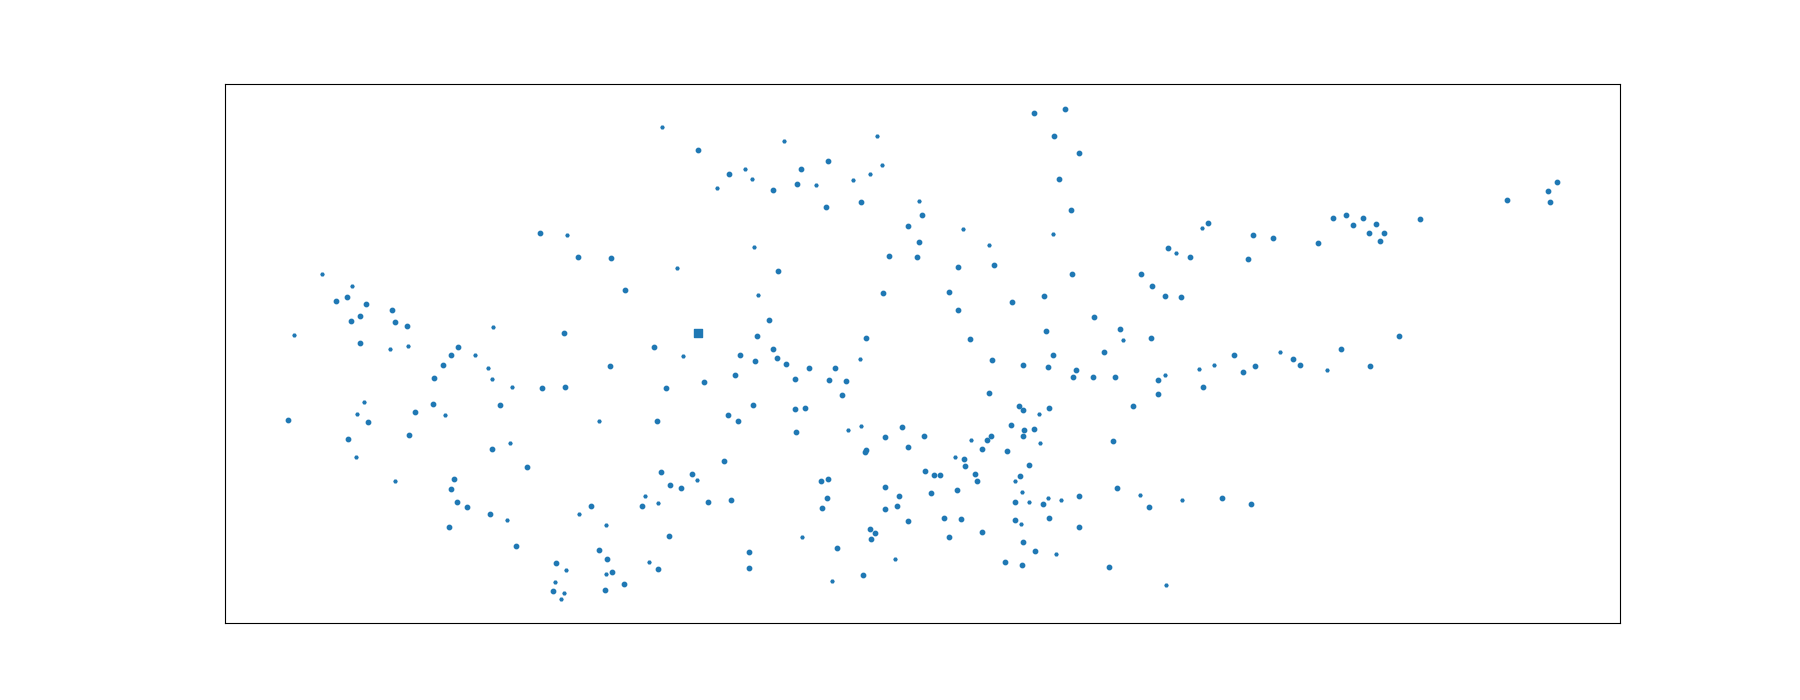

In [394]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
fig.clf()   
for node_type, shape in node_shapes.items():
    nodes = [i for i in node_labels if node_labels[i] == node_type]
    #node_size = node_sizes[node_type]##1
    if node_type == "REF":
        node_size = 30 
    elif node_type == "PQ":
        node_size = 10
    else:
        node_size = 5
    nx.draw_networkx_nodes(
        Gb,
        Gb_pos,
        nodelist=nodes,
        #node_color=[predicted_values[i] for i in nodes],
        #cmap=cmap,
        node_size=node_size,
        #ax=ax[0],
        #vmin=vmin,
        #vmax=vmax,
        node_shape=shape,
    )

In [ ]:
def display_grid(
        sel_line1,
        sel_line2,
        line_var,
        node_var
):
    """
    """

    fig, ax = plt.subplots(1, 2, figsize=(18, 7))
    
    for node_type, shape in node_shapes.items():
        nodes = [i for i in node_labels if node_labels[i] == node_type]
        node_size = 15 if node_type == "REF" else 7
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodes,
            #node_color=[predicted_values[i] for i in nodes],
            cmap=cmap,
            node_size=node_size,
            ax=ax[0],
            #vmin=vmin,
            #vmax=vmax,
            node_shape=shape,
        )
    #edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    #color_map = ['red' if w == 1 else 'darkgreen' for w in weights]
    #labels = {(u, v) : round(random.uniform(0., 20.), 2) for u, v in edges}
    

    edge_colors = ["gray"] * len(G.edges())
    edge_widths = [1] * len(G.edges())
    edge_colors[line_idx] = "red"
    edge_widths[line_idx] = 3
    #if grid_line_var == "G":
    #    edge_colors = g_vals
    #elif grid_line_var == "B":
    #    edge_colors = b_vals
    #vmin = np.min(edge_colors)
    #vmax = np.max(edge_colors)        

    #nx.draw_networkx_edges(G, pos, edge_color=color_map, alpha=1.0, ax=ax, width=1)
    nx.draw_networkx_edges(G, 
                           pos, 
                           edge_color=edge_colors, 
                           #edge_color=edge_colors,
                           
                           #edge_cmap=plt.cm.jet,
                           #edge_vmin = vmin,
                           #edge_vmax = vmax,
                           #alpha=1.0, 
                           ax=ax[0], 
                           width=edge_widths)
                           #width=1)
    
    #nx.draw_networkx_edge_labels(G,
    #                             pos, 
    #                             edge_labels=labels, 
    #                             font_size=3)
    # nx.draw_networkx_labels(
    #     G,
    #     pos,
    #     labels=node_labels,
    #     font_size=10,
    #     font_color="white",
    #     font_weight="bold",
    #     ax=ax,
    # )
    ax[0].set_title(f"Case300 Contingency Analysis", fontsize=14, fontweight="bold")

    ax[1].hist(c_data[line_idx], bins=50)

    #for spine in ax.spines.values():
    #    spine.set_linewidth(2)  # Adjust thickness


    #plt.subplots_adjust(right=0.9)
    plt.show()
    #return ax

In [389]:
sel_line1_slider = widgets.SelectionSlider(
    options=["None"] + list(np.arange(0, len(Gb.edges()))),
    value="None",
    description='Select Line 1',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width="25%", height='30px', padding='10px')
)

sel_line2_slider = widgets.SelectionSlider(
    options=["None"] + list(np.arange(0, len(Gb.edges()))),
    value="None",
    description='Select Line 2',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width="25%", height='30px', padding='10px')
)

line_vars = list(list(Gb.edges(data=True))[0][-1].keys())
sel_line_var_dropdown = widgets.Dropdown(
    options=line_vars,
    value=line_vars[0],
    description='Line Variable',
    disabled=False,
    layout=Layout(width="25%", height='30px', padding='10px')
)

node_vars = list(list(Gb.nodes(data=True))[0][-1].keys())
sel_node_var_dropdown = widgets.Dropdown(
    options=node_vars,
    value=node_vars[0],
    description='Bus Variable',
    disabled=False,
    layout=Layout(width="25%", height='30px', padding='10px')
)

hbox_line_sliders = widgets.HBox([sel_line1_slider, sel_line2_slider])
vbox_var_dropdowns = widgets.VBox([sel_line_var_dropdown, sel_node_var_dropdown])

def f(sel_line1, sel_line2, line_var, node_var):
    display_grid(sel_line1, sel_line2, line_var, node_var)
    #global G
    #for _ in range(n_cases):
    #clear_output()
    #G = update_graph(G, line_idx)
    #animate_edges(G, pos, num_nodes, node_labels,  plt.cm.viridis, line_idx, grid_line_var)
    #display(ax_)

widget_box = widgets.VBox([hbox_line_sliders, vbox_var_dropdowns])
widget_box.layout.height = '800px'
widget_box
# interactive_plot = widgets.interactive(f, 
#                                        sel_line1=sel_line1_slider, 
#                                        sel_line2=sel_line2_slider,
#                                        line_var=sel_line_var_dropdown,
#                                        node_var=sel_node_var_dropdown
#                                        )


In [ ]:
def update_graph(G, line_idx):
    """
    """
    
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    edges = [(u, v, random.randint(0, 1)) for u, v in edges]
    G.add_weighted_edges_from(edges)

    return G


def animate_edges(
    G, pos, num_nodes, node_labels, cmap, line_idx, grid_line_var
):
    """
    """
    #print(f"line_idx:", line_idx, type(line_idx))
    node_shapes = {"REF": "s", "PV": "H", "PQ": "o"}

    fig, ax = plt.subplots(1, 2, figsize=(18, 7))
    mplcursors.cursor(fig, hover=True)
    # Third plot (predicted values without masking)
    for node_type, shape in node_shapes.items():
        nodes = [i for i in node_labels if node_labels[i] == node_type]
        node_size = 15 if node_type == "REF" else 7
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodes,
            #node_color=[predicted_values[i] for i in nodes],
            cmap=cmap,
            node_size=node_size,
            ax=ax[0],
            #vmin=vmin,
            #vmax=vmax,
            node_shape=shape,
        )
    #edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    #color_map = ['red' if w == 1 else 'darkgreen' for w in weights]
    #labels = {(u, v) : round(random.uniform(0., 20.), 2) for u, v in edges}
    

    edge_colors = ["gray"] * len(G.edges())
    edge_widths = [1] * len(G.edges())
    edge_colors[line_idx] = "red"
    edge_widths[line_idx] = 3
    #if grid_line_var == "G":
    #    edge_colors = g_vals
    #elif grid_line_var == "B":
    #    edge_colors = b_vals
    #vmin = np.min(edge_colors)
    #vmax = np.max(edge_colors)        

    #nx.draw_networkx_edges(G, pos, edge_color=color_map, alpha=1.0, ax=ax, width=1)
    nx.draw_networkx_edges(G, 
                           pos, 
                           edge_color=edge_colors, 
                           #edge_color=edge_colors,
                           
                           #edge_cmap=plt.cm.jet,
                           #edge_vmin = vmin,
                           #edge_vmax = vmax,
                           #alpha=1.0, 
                           ax=ax[0], 
                           width=edge_widths)
                           #width=1)
    
    #nx.draw_networkx_edge_labels(G,
    #                             pos, 
    #                             edge_labels=labels, 
    #                             font_size=3)
    # nx.draw_networkx_labels(
    #     G,
    #     pos,
    #     labels=node_labels,
    #     font_size=10,
    #     font_color="white",
    #     font_weight="bold",
    #     ax=ax,
    # )
    ax[0].set_title(f"Case300 Contingency Analysis", fontsize=14, fontweight="bold")

    ax[1].hist(c_data[line_idx], bins=50)

    #for spine in ax.spines.values():
    #    spine.set_linewidth(2)  # Adjust thickness


    #plt.subplots_adjust(right=0.9)
    plt.show()
    #return ax

def f(line_idx, grid_line_var):
    #global G
    #for _ in range(n_cases):
    #clear_output()
    #G = update_graph(G, line_idx)
    animate_edges(G, pos, num_nodes, node_labels,  plt.cm.viridis, line_idx, grid_line_var)
    #display(ax_)




In [257]:
line_index_slider = widgets.SelectionSlider(
    options=list(np.arange(0, len(G.edges()))),
    value=1,
    description='Select Line',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

grid_line_var_dropdown = widgets.Dropdown(
    options=['G', 'B'],
    value='G',
    description='Line Var',
    disabled=False,
)


In [258]:
c_data = {}
global c_data
for lidx in range(0, len(G.edges())):
    data = np.random.normal(loc=0, scale=1, size=300)
    c_data[lidx] = data

In [259]:
#interactive_plot = widgets.interactive(f, n_cases=(1, 50, 5), top_k=['line 1', 'line 2'])
interactive_plot = widgets.interactive(f, 
                                       line_idx=line_index_slider, 
                                       grid_line_var=grid_line_var_dropdown)
#output = interactive_plot.children[-1]
#output.layout.height = '800px'
interactive_plot

interactive(children=(SelectionSlider(continuous_update=False, description='Select Line', index=1, options=(0,…

In [ ]:

# # using conductance (G) as an example of a line-variable to visualize for now
# edges = [
#         (u, v) # this random value should come from the contingency data
#         for u, v, g in zip(
#             edge_df["index1"].tolist(), edge_df["index2"].tolist(), edge_df["G"].tolist()
#         )
#         if u != v
#     ]
# G.add_edges_from(edges)

# global g_vals
# global b_vals
# g_vals = [
#         g # this random value should come from the contingency data
#         for u, v, g in zip(
#             edge_df["index1"].tolist(), edge_df["index2"].tolist(), edge_df["G"].tolist()
#         )
#         if u != v
#     ]

# b_vals = [
#         b # this random value should come from the contingency data
#         for u, v, b in zip(
#             edge_df["index1"].tolist(), edge_df["index2"].tolist(), edge_df["B"].tolist()
#         )
#         if u != v
#     ]
# #G.add_edges_from(edges)

# # Set node positions
# pos = nx.spring_layout(G, seed=4)
# #pos = nx.random_layout(G, seed=4)
# #pos = nx.planar_layout_layout(G, seed=42)

# # Assign labels based on node type
# node_shapes = {"REF": "s", "PV": "H", "PQ": "o"}
# num_nodes = node_df.shape[0]
# mask_PQ = node_df.loc[:, "PQ"] == 1
# mask_PV = node_df.loc[:, "PV"] == 1
# mask_REF = node_df.loc[:, "REF"] == 1
# node_labels = {}
# for i in range(num_nodes):
#     if mask_REF[i]:
#         node_labels[i] = "REF"
#     elif mask_PV[i]:
#         node_labels[i] = "PV"
#     elif mask_PQ[i]:
#         node_labels[i] = "PQ"

# num_nodes = len(node_df)